# Analysis of COVID-19 infections data in Italy

## Authors:
> **Jacopo Bartoli**  
> Università degli Studi di Firenze - Scuola di Ingegneria  
> jacopo.bartoli@stud.unifi.it  

> **Jason Ravagli**  
> Università degli Studi di Firenze - Scuola di Ingegneria  
> jason.ravagli@stud.unifi.it

---

## Outline
1. Introduction
2. Section 2
3. Section 3
4. ...

---

## 1. Introduction
We are all aware of the situation that the COVID-19 pandemic has caused in Italy during 2020. Starting from March 2020, the Italian Civil Protection (ICP) has begun to gather and make available daily data about contagious (such as the number of new positives, hospitalized infected, deaths, etc..) in our country to inform the population.

In addition to using the usual communication channels, the ICP created a [GitHub repository](https://github.com/pcm-dpc/COVID-19) to publish all the data and make them usable to research purposes. The main contributor to this repository is Umberto Rosini (https://github.com/umbros), an employee of the ICP.

The repository contains various kinds of data regarding the emergency and the infection, but in this notebook we focus on the analysis of two data files:

- https://github.com/pcm-dpc/COVID-19/blob/master/dati-json/dpc-covid19-ita-province.json
- https://github.com/pcm-dpc/COVID-19/blob/master/dati-json/dpc-covid19-ita-regioni.json

They contain the data about contagion day by day since 24th February 2020 and, at the time of writing (21st August 2020), they are updated every day at 18:30.  
The first file contains data divided by province, while the second one contains data divided by region.

**Summary**

### Setup environment

Importing required libraries:

In [43]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # To give a prettier style to charts
import geopandas as gpd # To plot maps. Transitive dependency: descartes

# Required to visualize maps in jupyter
%matplotlib inline
sns.set()

Define a function that allows to display multiple objects (e.g. dataframes) side by side:

In [5]:
class display(object):
    """Display HTML representation of multiple objects"""
    template = """<div style="float: left; padding: 10px;">
    <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
    </div>"""
    def __init__(self, *args):
        self.args = args
        
    def _repr_html_(self):
        return '\n'.join(self.template.format(a, eval(a)._repr_html_())
                         for a in self.args)
    
    def __repr__(self):
        return '\n\n'.join(a + '\n' + repr(eval(a))
                           for a in self.args)

## 2. Loading data

### Loading data as list of dictionaries

Inspecting the JSON files, we can observe that in each of them data are stored as an array of JSON objects. Therefore, we can load data in a list of Python dictionaries to take a first look at their structure.

In [6]:
with open("data/dpc-covid19-ita-regioni.json") as f:
    list_dict_reg = json.load(f)

In [7]:
with open("data/dpc-covid19-ita-province.json") as f:
    list_dict_prov = json.load(f)

In [8]:
list_dict_reg[0]

{'data': '2020-02-24T18:00:00',
 'stato': 'ITA',
 'codice_regione': 13,
 'denominazione_regione': 'Abruzzo',
 'lat': 42.35122196,
 'long': 13.39843823,
 'ricoverati_con_sintomi': 0,
 'terapia_intensiva': 0,
 'totale_ospedalizzati': 0,
 'isolamento_domiciliare': 0,
 'totale_positivi': 0,
 'variazione_totale_positivi': 0,
 'nuovi_positivi': 0,
 'dimessi_guariti': 0,
 'deceduti': 0,
 'casi_da_sospetto_diagnostico': None,
 'casi_da_screening': None,
 'totale_casi': 0,
 'tamponi': 5,
 'casi_testati': None,
 'note': None}

In [9]:
list_dict_prov[0]

{'data': '2020-02-24T18:00:00',
 'stato': 'ITA',
 'codice_regione': 13,
 'denominazione_regione': 'Abruzzo',
 'codice_provincia': 66,
 'denominazione_provincia': "L'Aquila",
 'sigla_provincia': 'AQ',
 'lat': 42.35122196,
 'long': 13.39843823,
 'totale_casi': 0,
 'note': None}

Each data object contains information about the cases of COVID-19 in a particular day for each region/province.
Data about regions contain exhaustive information about the detected cases, and a full explanation of each data field can be found [here](https://github.com/pcm-dpc/COVID-19/blob/master/dati-andamento-covid19-italia.md).

However it is not clear what the field *totale_casi* in the province data is about. In particular, from the documentation it is not clear if it refers to the currently positive cases in that province or to the overall detected cases.

### Loading data as Pandas dataframe

In [10]:
df_reg = pd.DataFrame(list_dict_reg)

In [11]:
df_prov = pd.DataFrame(list_dict_prov)

---

Let us take an overview at the region data.

In [12]:
df_reg.shape

(3738, 21)

In [13]:
df_reg.dtypes

data                             object
stato                            object
codice_regione                    int64
denominazione_regione            object
lat                             float64
long                            float64
ricoverati_con_sintomi            int64
terapia_intensiva                 int64
totale_ospedalizzati              int64
isolamento_domiciliare            int64
totale_positivi                   int64
variazione_totale_positivi        int64
nuovi_positivi                    int64
dimessi_guariti                   int64
deceduti                          int64
casi_da_sospetto_diagnostico    float64
casi_da_screening               float64
totale_casi                       int64
tamponi                           int64
casi_testati                    float64
note                             object
dtype: object

In [14]:
df_reg.head()

,data,stato,codice_regione,denominazione_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,...,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
0,2020-02-24T18:00:00,ITA,13,Abruzzo,42.351222,13.398438,0,0,0,0,...,0,0,0,0,NaN,NaN,0,5,NaN,None
1,2020-02-24T18:00:00,ITA,17,Basilicata,40.639471,15.805148,0,0,0,0,...,0,0,0,0,NaN,NaN,0,0,NaN,None
2,2020-02-24T18:00:00,ITA,18,Calabria,38.905976,16.594402,0,0,0,0,...,0,0,0,0,NaN,NaN,0,1,NaN,None
3,2020-02-24T18:00:00,ITA,15,Campania,40.839566,14.250850,0,0,0,0,...,0,0,0,0,NaN,NaN,0,10,NaN,None
4,2020-02-24T18:00:00,ITA,8,Emilia-Romagna,44.494367,11.341721,10,2,12,6,...,0,18,0,0,NaN,NaN,18,148,NaN,None


In [15]:
df_reg.describe()

,codice_regione,lat,long,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati
count,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,3738.000000,1176.000000,1176.000000,3738.000000,3.738000e+03,2583.000000
mean,11.857143,43.046293,12.225955,444.334136,50.146602,494.480738,1557.240770,2051.721509,4.050027,68.313002,5435.201980,1208.643125,10614.001701,1097.881803,8695.566613,1.607540e+05,137174.008904
std,6.274638,2.489114,2.659303,1323.771538,140.420552,1459.140050,3563.133122,4776.091041,185.709468,199.965627,11458.321257,2992.315037,19311.460927,1798.906944,17203.130676,2.438840e+05,145445.090715
min,1.000000,38.115697,7.320149,0.000000,0.000000,0.000000,0.000000,0.000000,-5339.000000,-229.000000,0.000000,0.000000,400.000000,0.000000,0.000000,0.000000e+00,3482.000000
25%,7.000000,41.125596,11.121231,9.000000,0.000000,10.000000,72.000000,87.250000,-12.000000,1.000000,245.250000,64.000000,1433.000000,17.000000,1100.000000,1.589075e+04,43673.500000
50%,12.000000,43.616760,12.388247,56.000000,5.000000,63.000000,320.000000,398.000000,0.000000,9.000000,1351.000000,291.000000,3348.000000,191.500000,3154.500000,7.786100e+04,83144.000000
75%,17.000000,45.434905,13.768136,255.000000,36.000000,294.000000,1313.750000,1648.250000,14.000000,48.000000,4404.000000,870.000000,8614.500000,1579.000000,7549.500000,1.888848e+05,182034.500000
max,22.000000,46.499335,16.867367,12077.000000,1381.000000,13328.000000,30382.000000,37307.000000,1950.000000,3251.000000,75398.000000,16844.000000,90487.000000,7485.000000,97564.000000,1.432476e+06,855372.000000


---

Now let us do the same thing for the province data.

In [16]:
df_prov.shape

(23960, 11)

In [17]:
df_prov.dtypes

data                        object
stato                       object
codice_regione               int64
denominazione_regione       object
codice_provincia             int64
denominazione_provincia     object
sigla_provincia             object
lat                        float64
long                       float64
totale_casi                  int64
note                        object
dtype: object

In [18]:
df_prov.head()

,data,stato,codice_regione,denominazione_regione,codice_provincia,denominazione_provincia,sigla_provincia,lat,long,totale_casi,note
0,2020-02-24T18:00:00,ITA,13,Abruzzo,66,L'Aquila,AQ,42.351222,13.398438,0,None
1,2020-02-24T18:00:00,ITA,13,Abruzzo,67,Teramo,TE,42.658918,13.704400,0,None
2,2020-02-24T18:00:00,ITA,13,Abruzzo,68,Pescara,PE,42.464584,14.213648,0,None
3,2020-02-24T18:00:00,ITA,13,Abruzzo,69,Chieti,CH,42.351032,14.167546,0,None
4,2020-02-24T18:00:00,ITA,13,Abruzzo,979,In fase di definizione/aggiornamento,None,NaN,NaN,0,None


In [19]:
df_prov.describe()

,codice_regione,codice_provincia,lat,long,totale_casi
count,23960.000000,23960.000000,19046.000000,19046.000000,23960.000000
mean,10.499499,240.971536,42.908522,12.096599,1356.585935
std,6.053899,369.370866,2.631578,2.660616,2748.219583
min,1.000000,1.000000,36.925092,7.320149,0.000000
25%,5.000000,34.000000,40.914047,9.828190,59.000000
50%,9.000000,68.000000,43.715532,12.104734,424.000000
75%,16.000000,101.000000,45.185093,14.167546,1367.000000
max,22.000000,999.000000,46.499335,18.171897,25297.000000


### Cleaning and preparing data

From the above tables we can observe that there are some useless data in both dataframes.
First of all we can drop the column `stato` from both, since the data all refer to the Italy (we can verify that `ITA` is the unique value).

In [20]:
df_reg['stato'].unique(), df_prov['stato'].unique()

(array(['ITA'], dtype=object), array(['ITA'], dtype=object))

In [21]:
df_reg = df_reg.drop(columns=["stato"])
df_prov = df_prov.drop(columns=["stato"])

Also the field `note` can be removed from the regions dataframe since it contains not useful plain textual data.

In [22]:
df_reg["note"].unique()

array([None, 'pd-IT-0002', 'pd-IT-0004', 'nd-IT-0001', 'nd-IT-0003',
       'nd-IT-0005', 'nd-IT-0008', 'nd-IT-0013', 'nd-IT-0011',
       'pd-IT-0006', 'pd-IT-0008', 'pd-IT-0010', 'dc-IT-0002',
       'dc-IT-0004', 'dc-IT-0006', 'pd-IT-0012', 'pd-IT-0014',
       'pd-IT-0016', 'dc-IT-0008', 'dc-IT-0010', 'dc-IT-0012',
       'dc-IT-0014', 'dc-IT-0016', 'dc-IT-0018', 'dc-IT-0020',
       'dc-IT-0022', 'dc-IT-0024', 'dc-IT-0026', 'dc-IT-0028',
       'dc-IT-0030', 'pd-IT-0018', 'dc-IT-0032', 'pd-IT-0020',
       'dc-IT-0034', 'dc-IT-0036', 'nd-IT-0015', 'pd-IT-0022',
       'dc-IT-0037', 'dc-IT-0038', 'dc-IT-0040', 'dc-IT-0042',
       'dc-IT-0046', 'dc-IT-0044', 'dc-IT-0048', 'dc-IT-0050',
       'dc-IT-0052', 'dc-IT-0054', 'dc-IT-0056', 'dc-EN-0058',
       'dc-IT-0062', 'dc-IT-0060', 'dc-IT-0064', 'dc-IT-0066',
       'dc-IT-0068', 'dc-IT-0070',
       'n.3 decessi precedentemente segnalati, da una revisione non risultano classificabili come COVID-19 positivi',
       'NEI CASI POSIT

In [23]:
df_prov["note"].unique()

array([None, 'pd-IT-0001', 'nd-IT-0007', 'nd-IT-0010', 'dc-IT-0001',
       'di cui 24 Stato estero', 'di cui 66 stato estero',
       "NEL TOTALE CASI POSITIVI SONO COMPRESI ULTERIORI N. 2 SOGGETTI RISULTATI POSITIVI PER ATTIVITA' DI SCREENING, ASINTOMATICI ED  IN ISOLAMENTO DOMICILIARE, NON RESIDENTI E PROVENIENTI DA STATO ESTERO.  ",
       "NEL TOTALE CASI POSITIVI SONO COMPRESI N. 2 SOGGETTI RISULTATI POSITIVI PER ATTIVITA' DI SCREENING, ASINTOMATICI ED  IN ISOLAMENTO DOMICILIARE, NON RESIDENTI E PROVENIENTI DA STATO ESTERO.  ",
       ' ',
       "NEL TOTALE CASI POSITIVI SONO COMPRESI N. 2 SOGGETTI RISULTATI POSITIVI PER ATTIVITA' DI SCREENING, PROVENIENTI DA STATO ESTERO.  ",
       'N. 1 NUOVO CASO POSITIVO DA SCREENING DI SOGGETTO RESIDENTE IN BASILICATA MA PROVENIENTE DA STATO ESTERO OVE SOGGIORNA PER MOTIVI DI LAVORO (KAZAKISTAN)',
       "NEL TOTALE CASI POSITIVI DA ATTIVITA' DI SCREENING SONO COMPRESI N. 2 SOGGETTI RISULTATI POSITIVI, PROVENIENTI DA STATO ESTERO (MOLDAVIA

In [24]:
df_reg = df_reg.drop(columns=["note"])
df_prov = df_prov.drop(columns=["note"])

Looking at the column types, we can see that the data under the columns `data` are stored as `object` in both dataframes. It is more appropriate to use the pandas `Timestamp` type, to facilitate queries.  
According to the documentation and to the size of data, for each day and region (for each day and province for the provinces dataframe) there is a unique entry, so for simplicity we can keep only the date without the time normalizing the column.

In [25]:
df_reg["data"] = pd.DatetimeIndex(df_reg["data"]).normalize()
df_prov["data"] = pd.DatetimeIndex(df_prov["data"]).normalize()

Finally, it would be useful for the next analysis to modify the indexes to use a multi-index with the date and regions for the regions data and a multi-index with the date and provinces for the provinces ones.

In [26]:
df_reg.set_index(["data", "denominazione_regione"], inplace=True)
df_prov.set_index(["data", "denominazione_regione", "sigla_provincia"], inplace=True)

Let us look at the obtained data:

## !!! Guarda il df delle province: NaN nell'index, droppare i dati non assegnati?

In [27]:
df_reg.tail()

codice_regione        lat       long  \
data       denominazione_regione                                         
2020-08-19 Sicilia                            19  38.115697  13.362357   
           Toscana                             9  43.769231  11.255889   
           Umbria                             10  43.106758  12.388247   
           Valle d'Aosta                       2  45.737503   7.320149   
           Veneto                              5  45.434905  12.338452   

                                  ricoverati_con_sintomi  terapia_intensiva  \
data       denominazione_regione                                              
2020-08-19 Sicilia                                    53                  8   
           Toscana                                    20                  5   
           Umbria                                      9                  2   
           Valle d'Aosta                               1                  0   
           Veneto                                     39                  6   

                                  totale_ospedalizzati  \
data       denominazione_regione                         
2020-08-19 Sicilia                                  61   
           Toscana                                  25   
           Umbria                                   11   
           Valle d'Aosta                             1   
           Veneto                                   45   

                                  isolamento_domiciliare  totale_positivi  \
data       denominazione_regione                                            
2020-08-19 Sicilia                                   705              766   
           Toscana                                   721              746   
           Umbria                                     84               95   
           Valle d'Aosta                               9               10   
           Veneto                                   1616             1661   

                                  variazione_totale_positivi  nuovi_positivi  \
data       denominazione_regione                                               
2020-08-19 Sicilia                                        44              45   
           Toscana                                        28              40   
           Umbria                                          2               4   
           Valle d'Aosta                                   2               2   
           Veneto                                        -27              59   

                                  dimessi_guariti  deceduti  \
data       denominazione_regione                              
2020-08-19 Sicilia                           2786       286   
           Toscana                           9040      1139   
           Umbria                            1388        80   
           Valle d'Aosta                     1064       146   
           Veneto                           17615      2099   

                                  casi_da_sospetto_diagnostico  \
data       denominazione_regione                                 
2020-08-19 Sicilia                                      3009.0   
           Toscana                                     10460.0   
           Umbria                                       1481.0   
           Valle d'Aosta                                1102.0   
           Veneto                                      19745.0   

                                  casi_da_screening  totale_casi  tamponi  \
data       denominazione_regione                                            
2020-08-19 Sicilia                            829.0         3838   315870   
           Toscana                            465.0        10925   479103   
           Umbria                              82.0         1563   136524   
           Valle d'Aosta                      118.0         1220    23634   
           Veneto                            1630.0        21375  1403390   

        

In [28]:
df_prov.tail()

codice_regione  \
data       denominazione_regione sigla_provincia                   
2020-08-19 Veneto                VE                            5   
                                 PD                            5   
                                 RO                            5   
                                 NaN                           5   
                                 NaN                           5   

                                                  codice_provincia  \
data       denominazione_regione sigla_provincia                     
2020-08-19 Veneto                VE                             27   
                                 PD                             28   
                                 RO                             29   
                                 NaN                           899   
                                 NaN                           999   

                                                               denominazione_provincia  \
data       denominazione_regione sigla_provincia                                         
2020-08-19 Veneto                VE                                            Venezia   
                                 PD                                             Padova   
                                 RO                                             Rovigo   
                                 NaN                Fuori Regione / Provincia Autonoma   
                                 NaN              In fase di definizione/aggiornamento   

                                                        lat       long  \
data       denominazione_regione sigla_provincia                         
2020-08-19 Veneto                VE               45.434905  12.338452   
                                 PD               45.406930  11.876087   
                                 RO               45.071073  11.790070   
                                 NaN                    NaN        NaN   
                                 NaN                    NaN        NaN   

                                                  totale_casi  
data       denominazione_regione sigla_provincia               
2020-08-19 Veneto                VE                      3047  
                                 PD                      4476  
                                 RO                       501  
                                 NaN                      333  
                                 NaN                       38

## 3. Analysis of national data

As a first step, let us analyze the data from a national point of view.

The simplest and obvious statistics to examine are the total number of deaths, healed and infected since the beginning of the pandemic and the death rate.

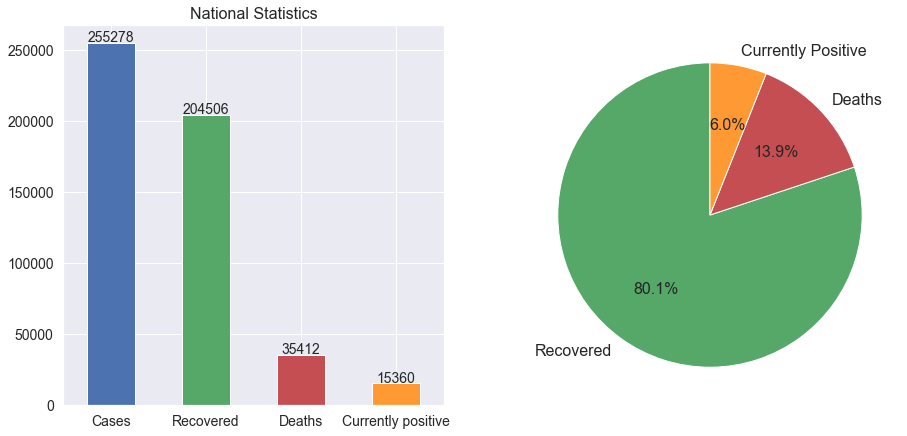

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15,7))

last_day = df_reg.index.max()[0]
tot_cases = df_reg.loc[last_day, "totale_casi"].sum()
tot_recovered = df_reg.loc[last_day, "dimessi_guariti"].sum()
tot_deaths = df_reg.loc[last_day, "deceduti"].sum()
currently_positive = tot_cases - (tot_recovered + tot_deaths)
index = ["Cases", "Recovered", "Deaths", "Currently positive"]

series = pd.Series([tot_cases, tot_recovered, tot_deaths, currently_positive], index=index)

color_list = ["b", "g", "r", "#ff9933"]
ax = series.plot(kind='bar', title="National Statistics", ax=axes[0], color=color_list, rot=0, fontsize=14)
ax.title.set_size(16)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+p.get_width()/2., p.get_height()), fontsize=14,
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')

index = ["Recovered", "Deaths", "Currently Positive"]
series = pd.Series([tot_recovered, tot_deaths, currently_positive], index = index)
color_list = ["g", "r", "#ff9933"]
ax = series.plot(kind='pie', ax=axes[1], colors=color_list, autopct='%1.1f%%',
        startangle=90, shadow=False, legend = False, fontsize=16)
ax.set_ylabel(None);


Since the beginning of the emergency the ICP registered that in Italy more than 250 thousand have been infected by COVID-19, with more than 35 thousand of victims (13.9% mortality).  
This death rate may appear huge, but doing some research it can be found that ICP data does not take into consideration the serological tests conducted by the ASLs. These tests revealed a lot of healed asymptomatic subjects that did not know they had been infected.

---

It could be interesting to study the national data trend over time.

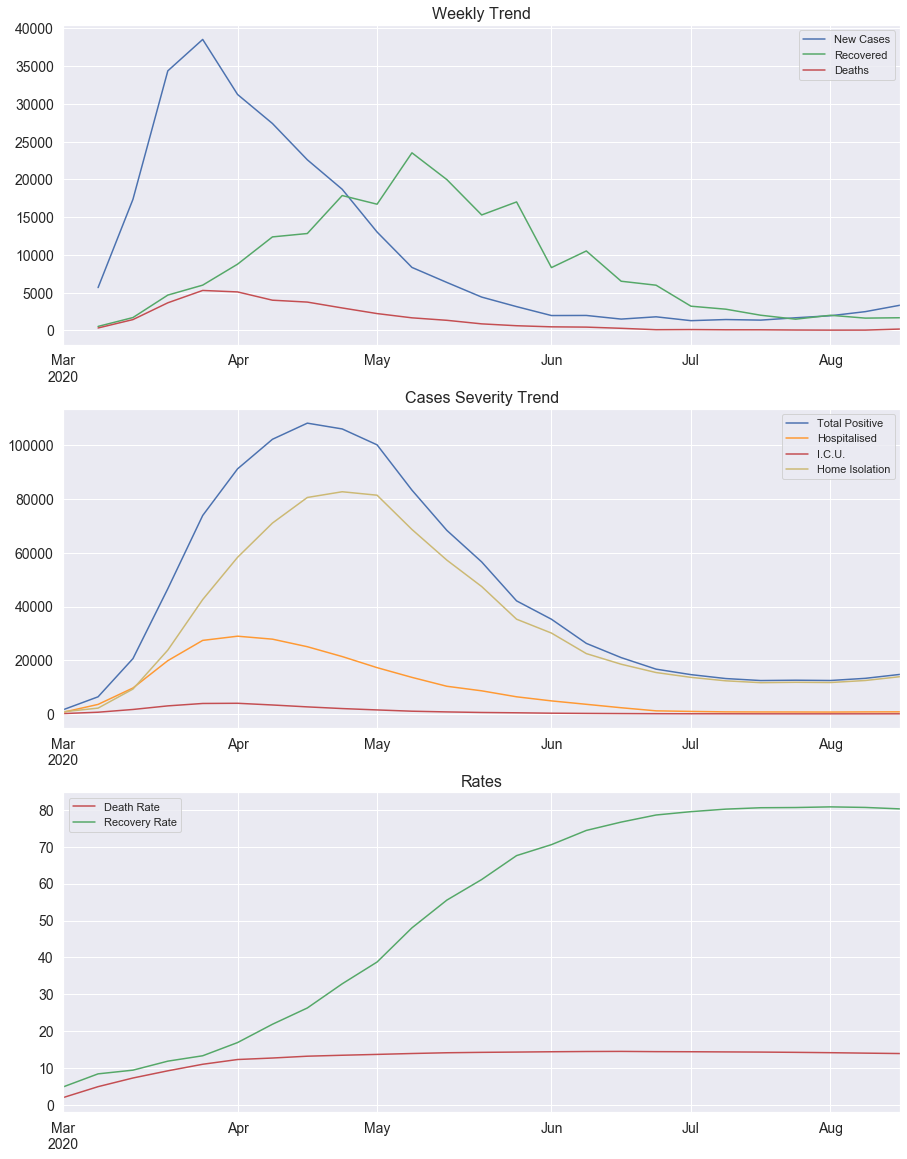

In [30]:
fig, axes = plt.subplots(3, 1, figsize=(15,20))
df_weekly_data = df_reg[["totale_casi", "dimessi_guariti", "deceduti"]].groupby(level="data").sum().asfreq("W")
df_weekly_trend = df_weekly_data - df_weekly_data.shift(+1)
df_weekly_trend.columns = ["New Cases", "Recovered", "Deaths"]

color_list = ["b", "g", "r"]
ax = df_weekly_trend.plot(title="Weekly Trend", ax=axes[0], color=color_list, fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

df_positives = df_reg[["totale_positivi", "ricoverati_con_sintomi", "terapia_intensiva", "isolamento_domiciliare"]].groupby(level="data").sum().asfreq("W")#.resample("W").sum()
df_positives.columns = ["Total Positive", "Hospitalised", "I.C.U.", "Home Isolation"]

color_list = ["b", "#ff9933", "r", "y"]
ax = df_positives.plot(title="Cases Severity Trend", ax=axes[1], color=color_list, fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

df_rates = df_weekly_data[["deceduti", "dimessi_guariti"]].div(df_weekly_data["totale_casi"], axis=0)*100
df_rates.columns = ["Death Rate", "Recovery Rate"]

color_list = ["r", "g"]
ax = df_rates.plot(title="Rates", ax=axes[2], color=color_list, fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

From the first chart we can observe a peak of new infected at the end of March (with almost 40 thousand of registered cases in a single week). Since then, the number of new infected continued to decline until June, when they stabilized at a few thousands of cases per week.  
The lockdown started in mid-March, and according to data it took about two weeks to show its results and about two months to get us out from the health emergency.  

Looking also at the second chart, the most of infected occured in April, but the severity of the disease (in terms of hospitalized and Intensive Care Unit subjects) was stronger at the end of March, the same period when the new infected peak occured. Since the start of April the subjects in home isolation were the most part of the detected cases. We can think that the huge growth of infected at the end of March made difficult to give adequate care to all the patients. In April the medical community began to gain experience on how to treat COVID-19 patients and the hospitals started receiving adequate equipment, hence the situation in the health facility gradually became treatable.

The precautions and the social distancing made sure that the contagion did not spread again after the end of the lockdown, but in the last weeks (the first of August) a new growth of infections had been registered. This is attributable to people returning from holidays in foreign country and not respecting the known rules on vacation.

We can also observe from the second chart that the death rate remained almost stable over the time.

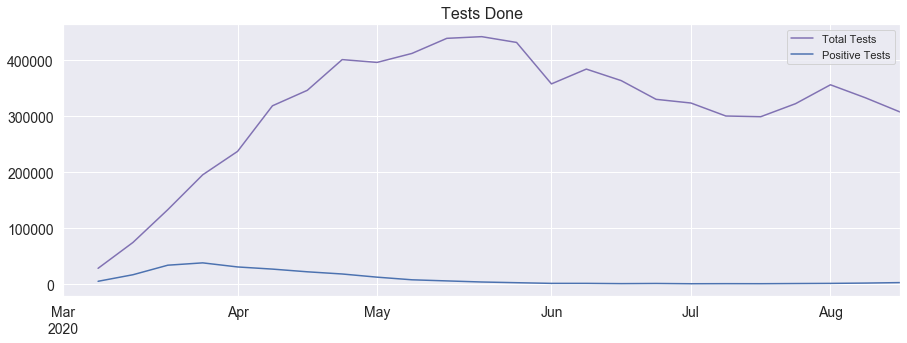

In [31]:
df_weekly_data = df_reg[["tamponi", "totale_casi"]].groupby(level=0).sum().asfreq("W")
df_weekly_trend = df_weekly_data - df_weekly_data.shift(+1)
df_weekly_trend.columns = ["Total Tests", "Positive Tests"]

color_list = ["m", "b"]
ax = df_weekly_trend.plot(title="Tests Done", color=color_list, figsize=(15, 5), fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

            totale_casi  casi_da_screening  casi_da_sospetto_diagnostico
data                                                                    
2020-07-05       241611            19243.0                      222368.0
2020-07-12       243061            21025.0                      222036.0
2020-07-19       244434            22254.0                      222180.0
2020-07-26       246118            23736.0                      222382.0
2020-08-02       248070            25193.0                      222877.0
            totale_casi  casi_da_screening  casi_da_sospetto_diagnostico
data                                                                    
2020-07-05          NaN                NaN                           NaN
2020-07-12     241611.0            19243.0                      222368.0
2020-07-19     243061.0            21025.0                      222036.0
2020-07-26     244434.0            22254.0                      222180.0
2020-08-02     246118.0            23736.0         

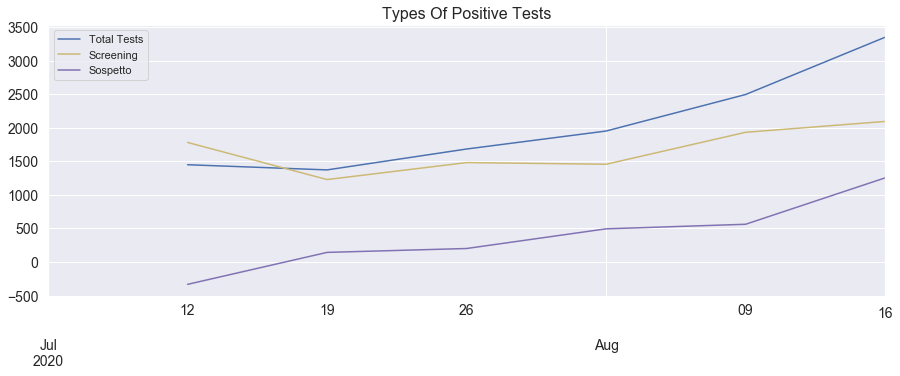

In [32]:
df_weekly_data = df_reg.loc['2020-07-01':][["totale_casi", "casi_da_screening", "casi_da_sospetto_diagnostico"]].groupby(level=0).sum().asfreq("W")

print(df_weekly_data.head())
df_weekly_trend = df_weekly_data - df_weekly_data.shift(+1)
print(df_weekly_data.shift(+1).head())
df_weekly_trend.columns = ["Total Tests", "Screening", "Sospetto"]

color_list = ["b", "y", "m"]
ax = df_weekly_trend.plot(title="Types Of Positive Tests", color=color_list, figsize=(15, 5), fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

Parlare dei pochi contagiati nonostante i test fatti?

## 4. Analysis of absolute regional data

In this section we want to analyze the data on a regional basis.

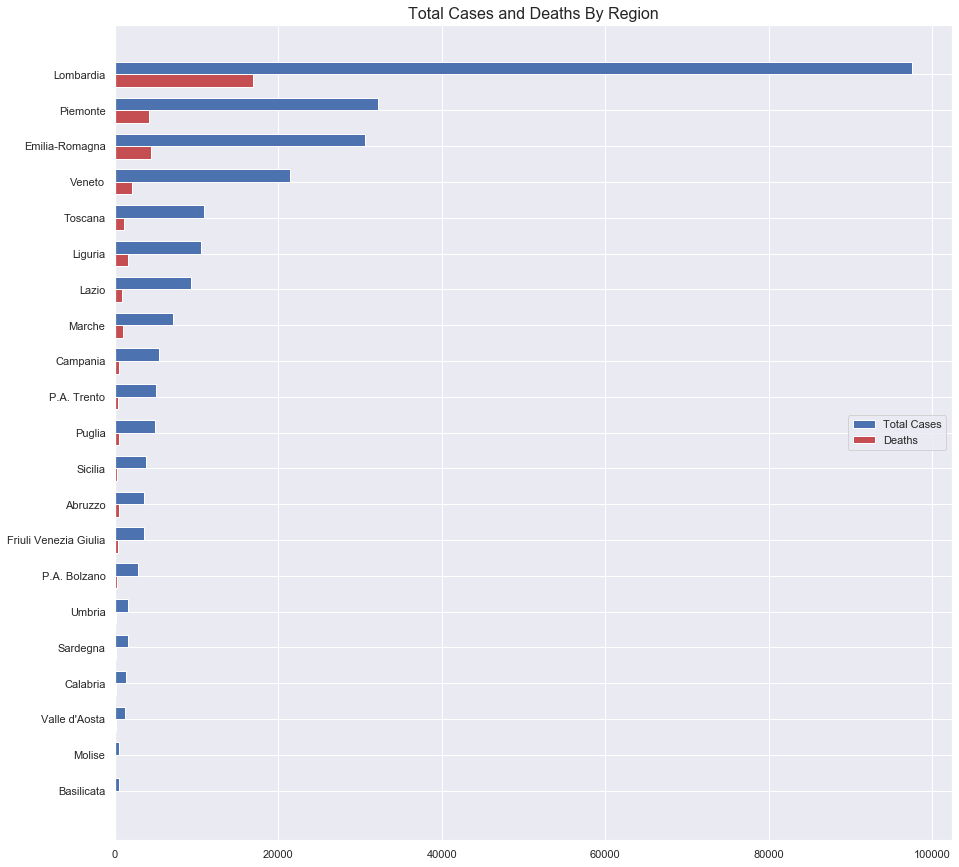

In [33]:
source_data = pd.DataFrame(df_reg.loc[last_day, ["totale_casi", "deceduti"]].sort_values("totale_casi", ascending=True)).reset_index()
ind = np.arange(len(source_data.index))  # the x locations for the groups
height = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 15))
rects1 = ax.barh(ind + height/2, source_data["totale_casi"], height,
                label='Total Cases', color="b")
rects2 = ax.barh(ind - height/2, source_data["deceduti"], height,
                label='Deaths', color="r")

ax.set_xlabel(None)
ax.set_title('Total Cases and Deaths By Region')
ax.set_yticks(ind)
ax.set_yticklabels(source_data["denominazione_regione"])
ax.legend(loc="center right");
ax.title.set_size(16)

We can observe that the most affected regions are the northern ones: Lombardia, Piemonte, Veneto and Emilia-Romagna. Furthermore Lombardia alone registered a huge number of total cases and deaths, that it is almost three times the ones of the second most affected region (Piemonte).
Among the least affected regions we can find almost all the southern region.

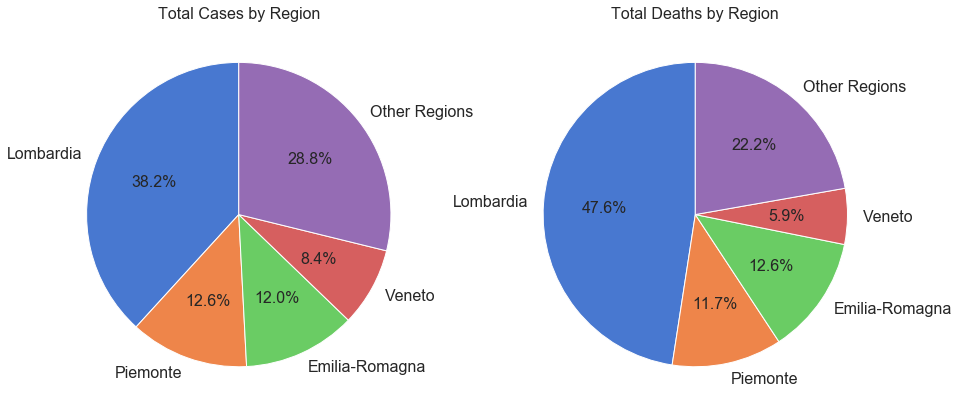

In [34]:
fig, axes = plt.subplots(1, 2, figsize=(15,7))
regions_of_interest = ["Lombardia", "Piemonte", "Emilia-Romagna", "Veneto"]
df_cases_by_region = df_reg.loc[last_day].pivot_table("totale_casi", index="denominazione_regione")
df_cases_of_interest = df_cases_by_region.loc[regions_of_interest]
df_cases_of_interest.loc["Other Regions"] = df_cases_by_region[~df_cases_by_region.index.isin(regions_of_interest)].sum()

ax = df_cases_of_interest.plot(kind='pie', ax=axes[0], title="Total Cases by Region", y="totale_casi",
                               colors=sns.color_palette("muted", len(df_cases_of_interest.index)),
                               autopct='%1.1f%%', startangle=90, shadow=False, legend = False, fontsize=16)
ax.set_ylabel(None)
ax.title.set_size(16);

df_deaths_by_region = df_reg.loc[last_day].pivot_table("deceduti", index="denominazione_regione")
df_deaths_of_interest = df_deaths_by_region.loc[regions_of_interest]
df_deaths_of_interest.loc["Other Regions"] = df_deaths_by_region[~df_deaths_by_region.index.isin(regions_of_interest)].sum()

ax = df_deaths_of_interest.plot(kind='pie', ax=axes[1], title="Total Deaths by Region", y="deceduti",
                               colors=sns.color_palette("muted", len(df_cases_of_interest.index)),
                               autopct='%1.1f%%', startangle=90, shadow=False, legend = False, fontsize=16)

ax.set_ylabel(None)
ax.title.set_size(16);

These pie charts show that the considered northern regions had over 70% of total infected italian people. It is interesting to note that Lombardia has almost 50% of the registered death.

---

It could be interesting to study the trend of data for each region over time, compared to the national average statistics.

In [35]:
df_inf_by_region = df_reg[["totale_casi", "deceduti"]].unstack().asfreq("W")
df_inf_by_region.head()

totale_casi                                              \
denominazione_regione     Abruzzo Basilicata Calabria Campania Emilia-Romagna   
data                                                                            
2020-03-01                      5          0        1       17            285   
2020-03-08                     17          4        9      101           1180   
2020-03-15                    137         11       68      333           3093   
2020-03-22                    587         81      273      936           7555   
2020-03-29                   1293        202      614     1759          13119   

                                                                            \
denominazione_regione Friuli Venezia Giulia Lazio Liguria Lombardia Marche   
data                                                                         
2020-03-01                                6     6      25       984     25   
2020-03-08                               57    87      78      4189    272   
2020-03-15                              347   436     559     13272   1133   
2020-03-22                              874  1383    1665     27206   2421   
2020-03-29                             1480  2706    3076     41007   3558   

                       ...     deceduti                                       \
denominazione_regione  ... P.A. Bolzano P.A. Trento Piemonte Puglia Sardegna   
data                   ...                                                     
2020-03-01             ...            0           0        0      0        0   
2020-03-08             ...            0           0        5      3        0   
2020-03-15             ...            5           6       81     16        2   
2020-03-22             ...           23          35      283     31        7   
2020-03-29             ...           64         129      684     86       27   

                                                                   
denominazione_regione Sicilia Toscana Umbria Valle d'Aosta Veneto  
data                                                               
2020-03-01                  0       0      0             0      2  
2020-03-08                  0       0      0             0     18  
2020-03-15                  2       8      1             1     63  
2020-03-22                  8      91     16             9    169  
2020-03-29                 65     215     31            43    392  

[5 rows x 42 columns]

In [36]:
df_national_mean = df_reg[["totale_casi", "deceduti"]].mean(level="data").asfreq("W")
df_national_mean.head()

,totale_casi,deceduti
data,,
2020-03-01,80.666667,1.619048
2020-03-08,351.190476,17.428571
2020-03-15,1178.428571,86.142857
2020-03-22,2816.095238,260.761905
2020-03-29,4651.857143,513.285714


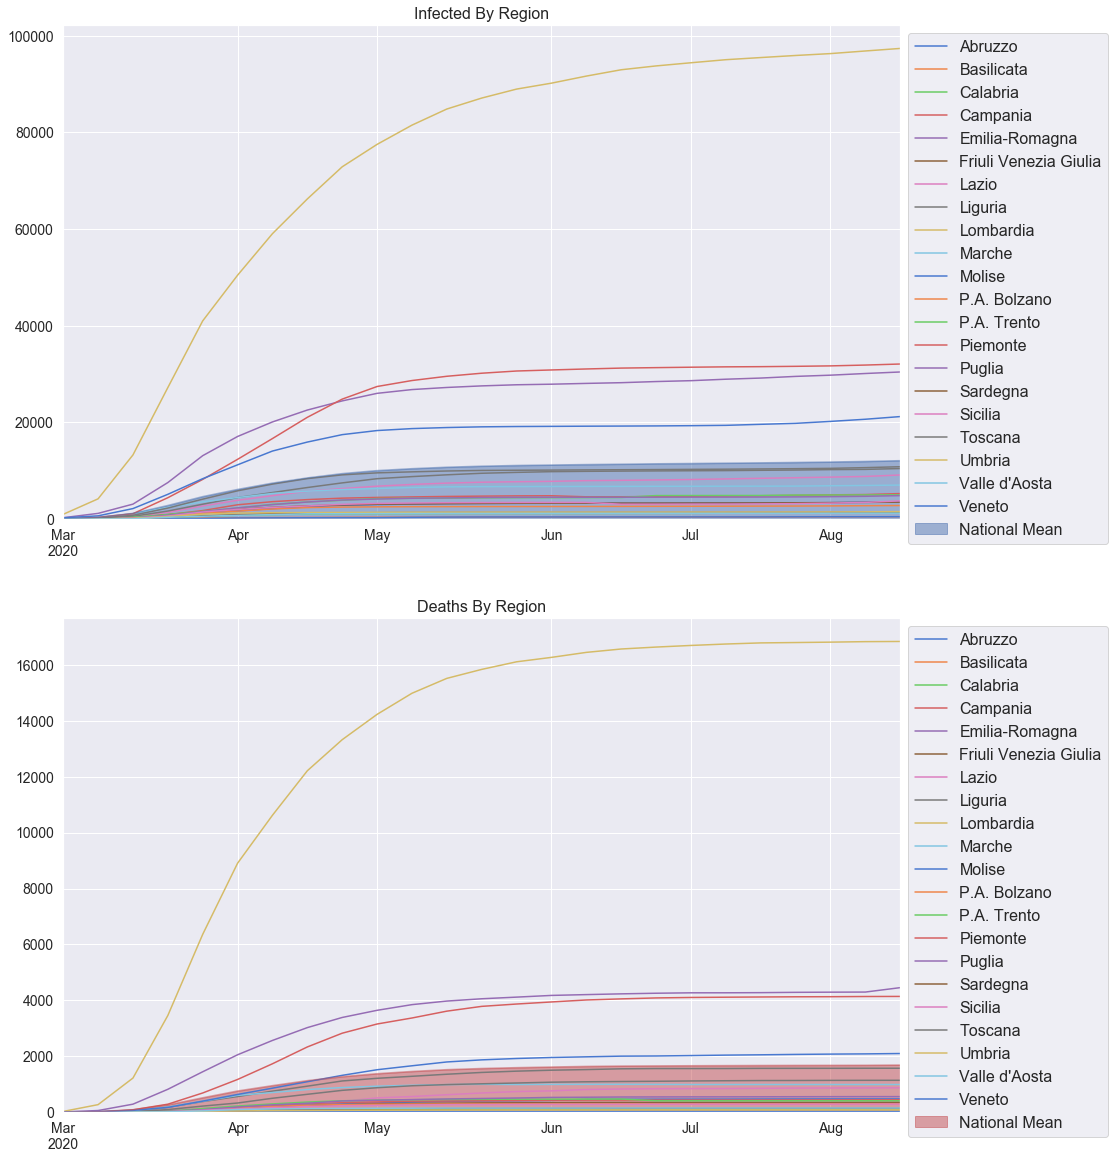

In [37]:
fig, axes = plt.subplots(2, 1, figsize=(15,20))

# Plot infected trend
ax = df_inf_by_region["totale_casi"].plot(title="Infected By Region", ax=axes[0],
                           color=sns.color_palette("muted", len(df_inf_by_region.index)), fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

ax = df_national_mean["totale_casi"].plot.area(ax=axes[0], alpha=0.5)
ax.set_xlabel(None)
ax.legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.0, 1.0));
ax.get_legend().texts[-1].set_text("National Mean")

# Plot death trend
ax = df_inf_by_region["deceduti"].plot(title="Deaths By Region", ax=axes[1],
                           color=sns.color_palette("muted", len(df_inf_by_region.index)), fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

ax = df_national_mean["deceduti"].plot.area(ax=axes[1], alpha=0.5, color='r')
ax.set_xlabel(None)
ax.legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.0, 1.0));
ax.get_legend().texts[-1].set_text("National Mean")

Qualche considerazione.

---

Let us do the same thing to evaluate the severity of cases by region over time.

In [38]:
df_severity_by_reg = df_reg[["ricoverati_con_sintomi", "terapia_intensiva"]].unstack().asfreq("W")
df_severity_by_reg.head()

ricoverati_con_sintomi                               \
denominazione_regione                Abruzzo Basilicata Calabria Campania   
data                                                                        
2020-03-01                                 3          0        0        4   
2020-03-08                                14          2        5       30   
2020-03-15                                72          0       32       73   
2020-03-22                               218         13       77      243   
2020-03-29                               329         32      124      476   

                                                                          \
denominazione_regione Emilia-Romagna Friuli Venezia Giulia Lazio Liguria   
data                                                                       
2020-03-01                       127                     0     3      12   
2020-03-08                       542                     7    47      39   
2020-03-15                      1215                    98   223     253   
2020-03-22                      2429                   163   671     736   
2020-03-29                      3769                   236  1062    1077   

                                        ... terapia_intensiva              \
denominazione_regione Lombardia Marche  ...      P.A. Bolzano P.A. Trento   
data                                    ...                                 
2020-03-01                  406     12  ...                 0           0   
2020-03-08                 2217    110  ...                 0           2   
2020-03-15                 5500    521  ...                 4          19   
2020-03-22                 9439    816  ...                32          46   
2020-03-29                11613   1000  ...                56          75   

                                                                       \
denominazione_regione Piemonte Puglia Sardegna Sicilia Toscana Umbria   
data                                                                    
2020-03-01                   2      0        0       0       0      0   
2020-03-08                  45      3        0       0       7      2   
2020-03-15                 171      6        0      15     107     13   
2020-03-22                 308     37       16      55     215     35   
2020-03-29                 443     99       23      71     275     46   

                                            
denominazione_regione Valle d'Aosta Veneto  
data                                        
2020-03-01                        0     13  
2020-03-08                        0     47  
2020-03-15                        3    129  
2020-03-22                       21    255  
2020-03-29                       26    355  

[5 rows x 42 columns]

In [39]:
df_national_mean = df_reg[["ricoverati_con_sintomi", "terapia_intensiva"]].mean(level="data").asfreq("W")
df_national_mean.head()

,ricoverati_con_sintomi,terapia_intensiva
data,,
2020-03-01,30.428571,6.666667
2020-03-08,169.380952,30.952381
2020-03-15,460.142857,79.619048
2020-03-22,945.047619,143.285714
2020-03-29,1304.095238,186.000000


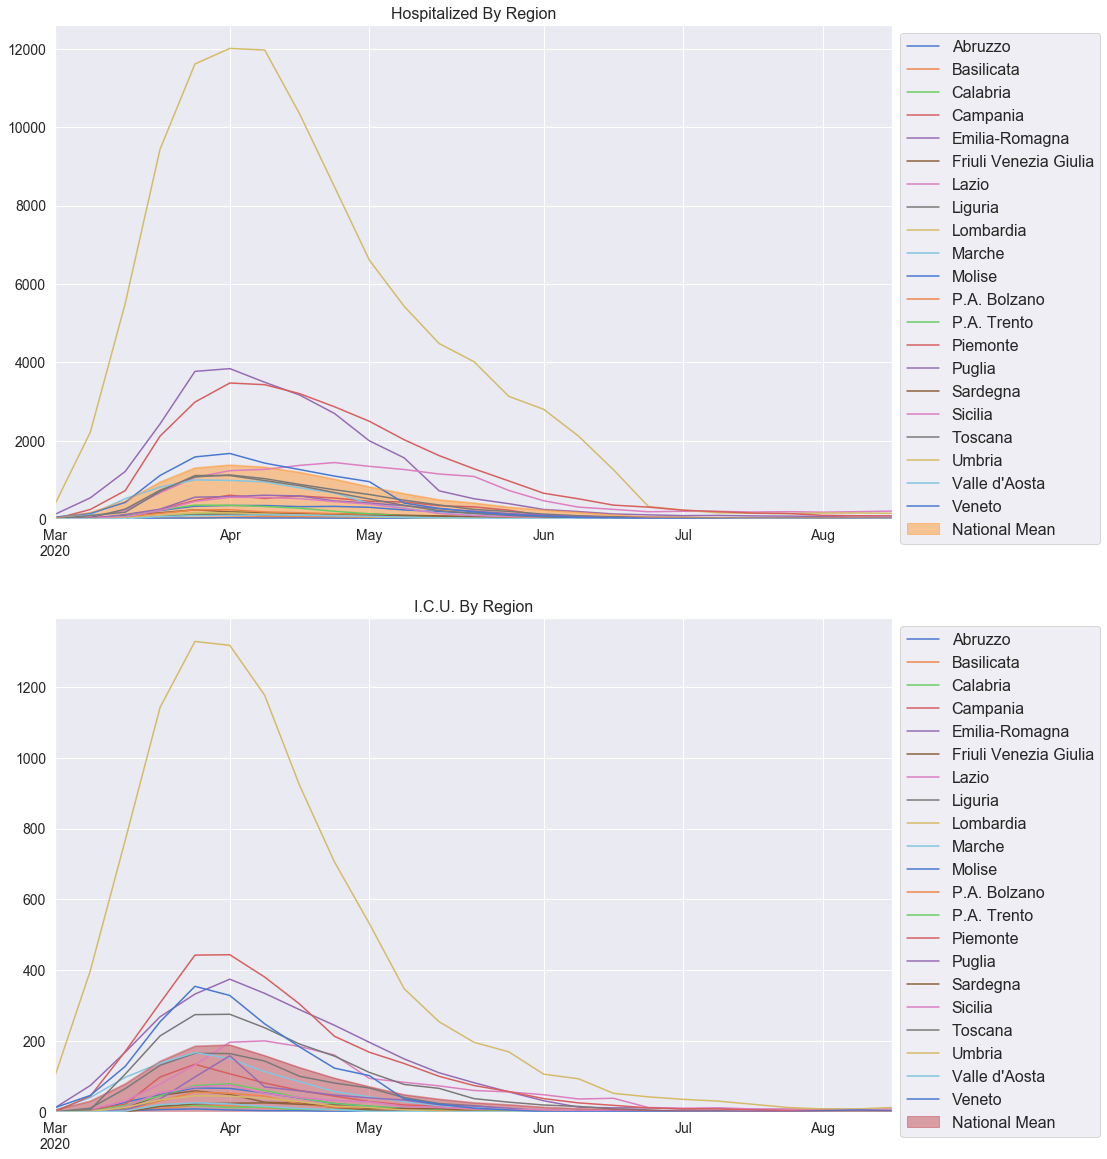

In [40]:
fig, axes = plt.subplots(2, 1, figsize=(15,20))

# Plot hospitalized trend
ax = df_severity_by_reg["ricoverati_con_sintomi"].plot(title="Hospitalized By Region", ax=axes[0],
                           color=sns.color_palette("muted", len(df_inf_by_region.index)), fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

ax = df_national_mean["ricoverati_con_sintomi"].plot.area(ax=axes[0], color="#ff9933", alpha=0.5)
ax.set_xlabel(None)
ax.legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.0, 1.0));
ax.get_legend().texts[-1].set_text("National Mean")

# Plot ICU trend
ax = df_severity_by_reg["terapia_intensiva"].plot(title="I.C.U. By Region", ax=axes[1],
                           color=sns.color_palette("muted", len(df_inf_by_region.index)), fontsize=14)
ax.set_xlabel(None)
ax.title.set_size(16)

ax = df_national_mean["terapia_intensiva"].plot.area(ax=axes[1], color="r", alpha=0.5)
ax.set_xlabel(None)
ax.legend(fontsize=16,loc='upper left', bbox_to_anchor=(1.0, 1.0));
ax.get_legend().texts[-1].set_text("National Mean")

Qualche considerazione

## 5. Analysis of regional data with respect to the population

In this section we want to analyze the same data of the previous section but compared to the population of each region.

We first load the italian population data updated in January 2020. These data can be found at [http://dati.istat.it/Index.aspx?DataSetCode=DCIS_POPRES1](http://dati.istat.it/Index.aspx?DataSetCode=DCIS_POPRES1), however we had to a manual clean operation to transform the .xls file into a readable .csv one because of some errors in the csv file generated by ISTAT.

In [88]:
df_pop = pd.read_csv(os.path.join("data", "italian-population.csv"), sep=";")
df_pop.head()

,Territorio,totale
0,Italia,60244639
1,Nord-ovest,16113972
2,Piemonte,4341375
3,Torino,2252379
4,Vercelli,170296


Rename the column *totale* to avoid confusion:

In [112]:
df_pop = df_pop.rename(columns={"totale": "popolazione"})
df_pop.head()

,Territorio,popolazione
0,Italia,60244639
1,Nord-ovest,16113972
2,Piemonte,4341375
3,Torino,2252379
4,Vercelli,170296


In [113]:
df_pop["Territorio"].unique()

array(['Italia', 'Nord-ovest', 'Piemonte', 'Torino', 'Vercelli', 'Novara',
       'Cuneo', 'Asti', 'Alessandria', 'Biella', 'Verbano-Cusio-Ossola',
       "Valle d'Aosta / Vallée d'Aoste", 'Liguria', 'Imperia', 'Savona',
       'Genova', 'La Spezia', 'Lombardia', 'Varese', 'Como', 'Sondrio',
       'Milano', 'Bergamo', 'Brescia', 'Pavia', 'Cremona', 'Mantova',
       'Lecco', 'Lodi', 'Monza e della Brianza', 'Nord-est',
       'Trentino Alto Adige / Südtirol',
       'Provincia Autonoma Bolzano / Bozen', 'Bolzano / Bozen',
       'Provincia Autonoma Trento', 'Trento', 'Veneto', 'Verona',
       'Vicenza', 'Belluno', 'Treviso', 'Venezia', 'Padova', 'Rovigo',
       'Friuli-Venezia Giulia', 'Udine', 'Gorizia', 'Trieste',
       'Pordenone', 'Emilia-Romagna', 'Piacenza', 'Parma',
       "Reggio nell'Emilia", 'Modena', 'Bologna', 'Ferrara', 'Ravenna',
       'Forlì-Cesena', 'Rimini', 'Centro', 'Toscana', 'Massa-Carrara',
       'Lucca', 'Pistoia', 'Firenze', 'Livorno', 'Pisa', 'Arezzo',
  

We need to remove the whitespaces from the value in order to merge the dataframe with our data:

In [114]:
df_pop["Territorio"] = df_pop["Territorio"].map(lambda x: x.strip())
df_pop["Territorio"].unique()

array(['Italia', 'Nord-ovest', 'Piemonte', 'Torino', 'Vercelli', 'Novara',
       'Cuneo', 'Asti', 'Alessandria', 'Biella', 'Verbano-Cusio-Ossola',
       "Valle d'Aosta / Vallée d'Aoste", 'Liguria', 'Imperia', 'Savona',
       'Genova', 'La Spezia', 'Lombardia', 'Varese', 'Como', 'Sondrio',
       'Milano', 'Bergamo', 'Brescia', 'Pavia', 'Cremona', 'Mantova',
       'Lecco', 'Lodi', 'Monza e della Brianza', 'Nord-est',
       'Trentino Alto Adige / Südtirol',
       'Provincia Autonoma Bolzano / Bozen', 'Bolzano / Bozen',
       'Provincia Autonoma Trento', 'Trento', 'Veneto', 'Verona',
       'Vicenza', 'Belluno', 'Treviso', 'Venezia', 'Padova', 'Rovigo',
       'Friuli-Venezia Giulia', 'Udine', 'Gorizia', 'Trieste',
       'Pordenone', 'Emilia-Romagna', 'Piacenza', 'Parma',
       "Reggio nell'Emilia", 'Modena', 'Bologna', 'Ferrara', 'Ravenna',
       'Forlì-Cesena', 'Rimini', 'Centro', 'Toscana', 'Massa-Carrara',
       'Lucca', 'Pistoia', 'Firenze', 'Livorno', 'Pisa', 'Arezzo',
  

In [141]:
# Retrieve the regional data of interest, sampled by week
# We need to reset the index to merge it with the population dataframe
df = df_reg[["totale_casi", "tamponi", "totale_positivi"]].unstack().asfreq("W").stack().reset_index()
df_reg_relative = df.merge(df_pop, left_on="denominazione_regione", right_on="Territorio")
# Drop duplicate column
df_reg_relative = df_reg_relative.drop(columns="Territorio")
df_reg_relative.head()

,data,denominazione_regione,totale_casi,tamponi,totale_positivi,popolazione
0,2020-03-01,Abruzzo,5,52,5,1305770
1,2020-03-08,Abruzzo,17,163,17,1305770
2,2020-03-15,Abruzzo,137,1419,128,1305770
3,2020-03-22,Abruzzo,587,3375,539,1305770
4,2020-03-29,Abruzzo,1293,7730,1169,1305770


Divide columns *totale_casi*, *tamponi* and *totale_positivi* by *popolazione* to get the relative data (percentage) over the time:

In [142]:
df_reg_relative[["totale_casi", "tamponi", "totale_positivi"]] = df_reg_relative[["totale_casi", "tamponi", "totale_positivi"]].div(df_reg_pop["popolazione"]/100, axis=0)
df_reg_relative.head()

,data,denominazione_regione,totale_casi,tamponi,totale_positivi,popolazione
0,2020-03-01,Abruzzo,0.000383,0.003982,0.000383,1305770
1,2020-03-08,Abruzzo,0.001302,0.012483,0.001302,1305770
2,2020-03-15,Abruzzo,0.010492,0.108672,0.009803,1305770
3,2020-03-22,Abruzzo,0.044954,0.258468,0.041278,1305770
4,2020-03-29,Abruzzo,0.099022,0.591988,0.089526,1305770


Rebuild the index using *data* and *denominazione_regione*:

In [143]:
df_reg_relative = df_reg_relative.set_index(['data', 'denominazione_regione'])
df_reg_relative.sort_index(inplace=True)
df_reg_relative.head()

totale_casi   tamponi  totale_positivi  \
data       denominazione_regione                                           
2020-03-01 Abruzzo                   0.000383  0.003982         0.000383   
           Basilicata                0.000000  0.007003         0.000000   
           Calabria                  0.000052  0.001818         0.000052   
           Campania                  0.000294  0.006447         0.000294   
           Emilia-Romagna            0.006380  0.040183         0.006201   

                                  popolazione  
data       denominazione_regione               
2020-03-01 Abruzzo                    1305770  
           Basilicata                  556934  
           Calabria                   1924701  
           Campania                   5785861  
           Emilia-Romagna             4467118

In [144]:
df_reg_relative.describe()

,totale_casi,tamponi,totale_positivi,popolazione
count,425.000000,425.000000,425.000000,4.250000e+02
mean,0.238567,5.258474,0.056235,3.401939e+06
std,0.245164,4.826160,0.077496,2.484106e+06
min,0.000000,0.001779,0.000000,3.022650e+05
25%,0.066868,1.172132,0.007482,1.518400e+06
50%,0.133185,4.411681,0.021925,3.722729e+06
75%,0.385944,7.908877,0.066660,4.907704e+06
max,0.963780,27.952521,0.365460,1.010397e+07


Qualche considerazione su queste percentuali

---



In [149]:
last_day = df_reg_relative.index[-1][0]
source_data = pd.DataFrame(df_reg_relative.loc[last_day, ["totale_casi", "tamponi"]].sort_values("totale_casi", ascending=True)).reset_index()
source_data

,denominazione_regione,totale_casi,tamponi
0,Calabria,0.070037,7.052524
1,Sicilia,0.075799,6.218871
2,Basilicata,0.087084,9.131603
3,Campania,0.091222,6.254782
4,Sardegna,0.091568,7.221458
5,Puglia,0.121199,6.670515
6,Lazio,0.155604,7.807528
7,Molise,0.161117,9.911171
8,Umbria,0.175852,15.111015
9,Abruzzo,0.272636,10.792483


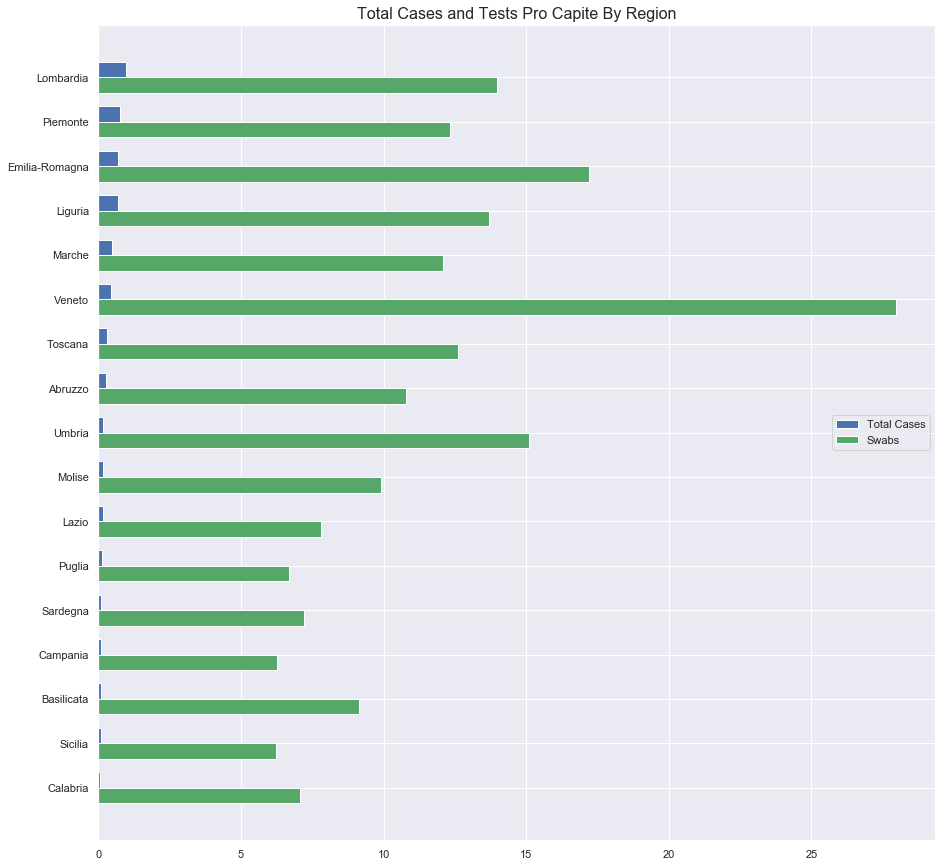

In [150]:
ind = np.arange(len(source_data.index))
height = 0.35

fig, ax = plt.subplots(figsize=(15, 15))
rects1 = ax.barh(ind + height/2, source_data["totale_casi"], height,
                label='Total Cases', color="b")
rects2 = ax.barh(ind - height/2, source_data["tamponi"], height,
                label='Swabs', color="g")

ax.set_xlabel(None)
ax.set_title('Total Cases and Tests Pro Capite By Region')
ax.set_yticks(ind)
ax.set_yticklabels(source_data["denominazione_regione"])
ax.legend(loc="center right");
ax.title.set_size(16)

## 6. Geographical analysis using maps

In this section we analyze the data from a geographical point of view using maps.
Following the examples found at this [GitHub repository](https://github.com/napo/geopandas_esempi) we can use ISTAT geographical data to translate our data into geographical heatmaps and scatter plots.  
The geographical data can be found at [https://www.istat.it/it/archivio/222527](https://www.istat.it/it/archivio/222527).

First of all we need to load the regions border data.

In [73]:
geo_regions = gpd.read_file(os.path.join("data", "Limiti01012020", "Reg01012020", "Reg01012020_WGS84.shp"))
geo_regions.head()

,COD_RIP,COD_REG,DEN_REG,SHAPE_AREA,SHAPE_LEN,geometry
0,1,1,Piemonte,2.538670e+10,1.333428e+06,"POLYGON ((456874.626 5145767.794, 456879.627 5..."
1,1,2,Valle d'Aosta,3.260854e+09,3.258364e+05,"POLYGON ((389358.653 5093659.158, 389433.654 5..."
2,1,3,Lombardia,2.386310e+10,1.511132e+06,"MULTIPOLYGON (((595652.358 5163515.659, 595847..."
3,2,4,Trentino-Alto Adige,1.360472e+10,8.598731e+05,"POLYGON ((743387.812 5219741.793, 743414.749 5..."
4,2,5,Veneto,1.834537e+10,1.140433e+06,"POLYGON ((768135.210 5175357.497, 768146.460 5..."


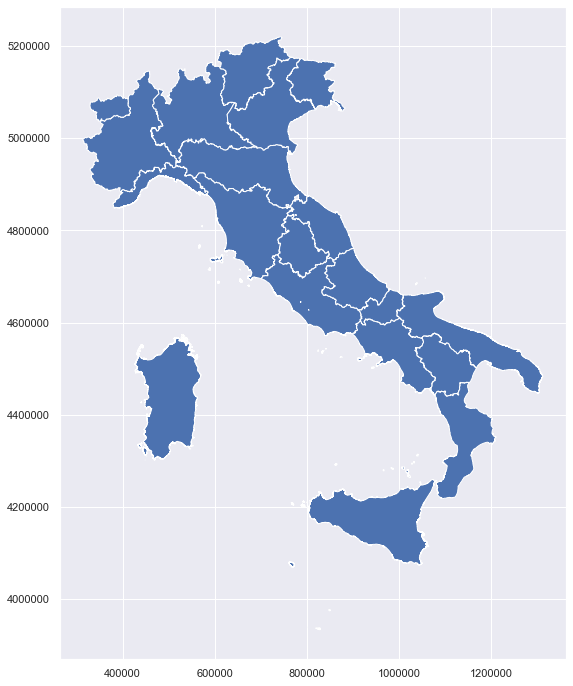

In [74]:
geo_regions.plot(figsize=(10, 12));

Now we can merge our data to the geographical ones.

In [78]:
last_day = df_reg.index.max()[0]
geo_data_by_region = geo_regions.merge(df_reg.loc[last_day].reset_index(), how="left",
                                       left_on="DEN_REG", right_on="denominazione_regione")
# Drop duplicates columns
geo_data_by_region.drop(["denominazione_regione", "codice_regione"], axis="columns", inplace=True)
# Data from Bolzano and Trento need to be added up into a unique row to form the Trentino-Alto Adige data
geo_data_by_region.head()

,COD_RIP,COD_REG,DEN_REG,SHAPE_AREA,SHAPE_LEN,geometry,lat,long,ricoverati_con_sintomi,terapia_intensiva,...,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati
0,1,1,Piemonte,2.538670e+10,1.333428e+06,"POLYGON ((456874.626 5145767.794, 456879.627 5...",45.073274,7.680687,81.0,3.0,...,931.0,34.0,42.0,27096.0,4142.0,24684.0,7485.0,32169.0,543744.0,330412.0
1,1,2,Valle d'Aosta,3.260854e+09,3.258364e+05,"POLYGON ((389358.653 5093659.158, 389433.654 5...",45.737503,7.320149,1.0,0.0,...,10.0,2.0,2.0,1064.0,146.0,1102.0,118.0,1220.0,23634.0,16823.0
2,1,3,Lombardia,2.386310e+10,1.511132e+06,"MULTIPOLYGON (((595652.358 5163515.659, 595847...",45.466794,9.190347,151.0,14.0,...,5322.0,8.0,91.0,75398.0,16844.0,90487.0,7077.0,97564.0,1432476.0,855372.0
3,2,4,Trentino-Alto Adige,1.360472e+10,8.598731e+05,"POLYGON ((743387.812 5219741.793, 743414.749 5...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,5,Veneto,1.834537e+10,1.140433e+06,"POLYGON ((768135.210 5175357.497, 768146.460 5...",45.434905,12.338452,39.0,6.0,...,1661.0,-27.0,59.0,17615.0,2099.0,19745.0,1630.0,21375.0,1403390.0,546505.0


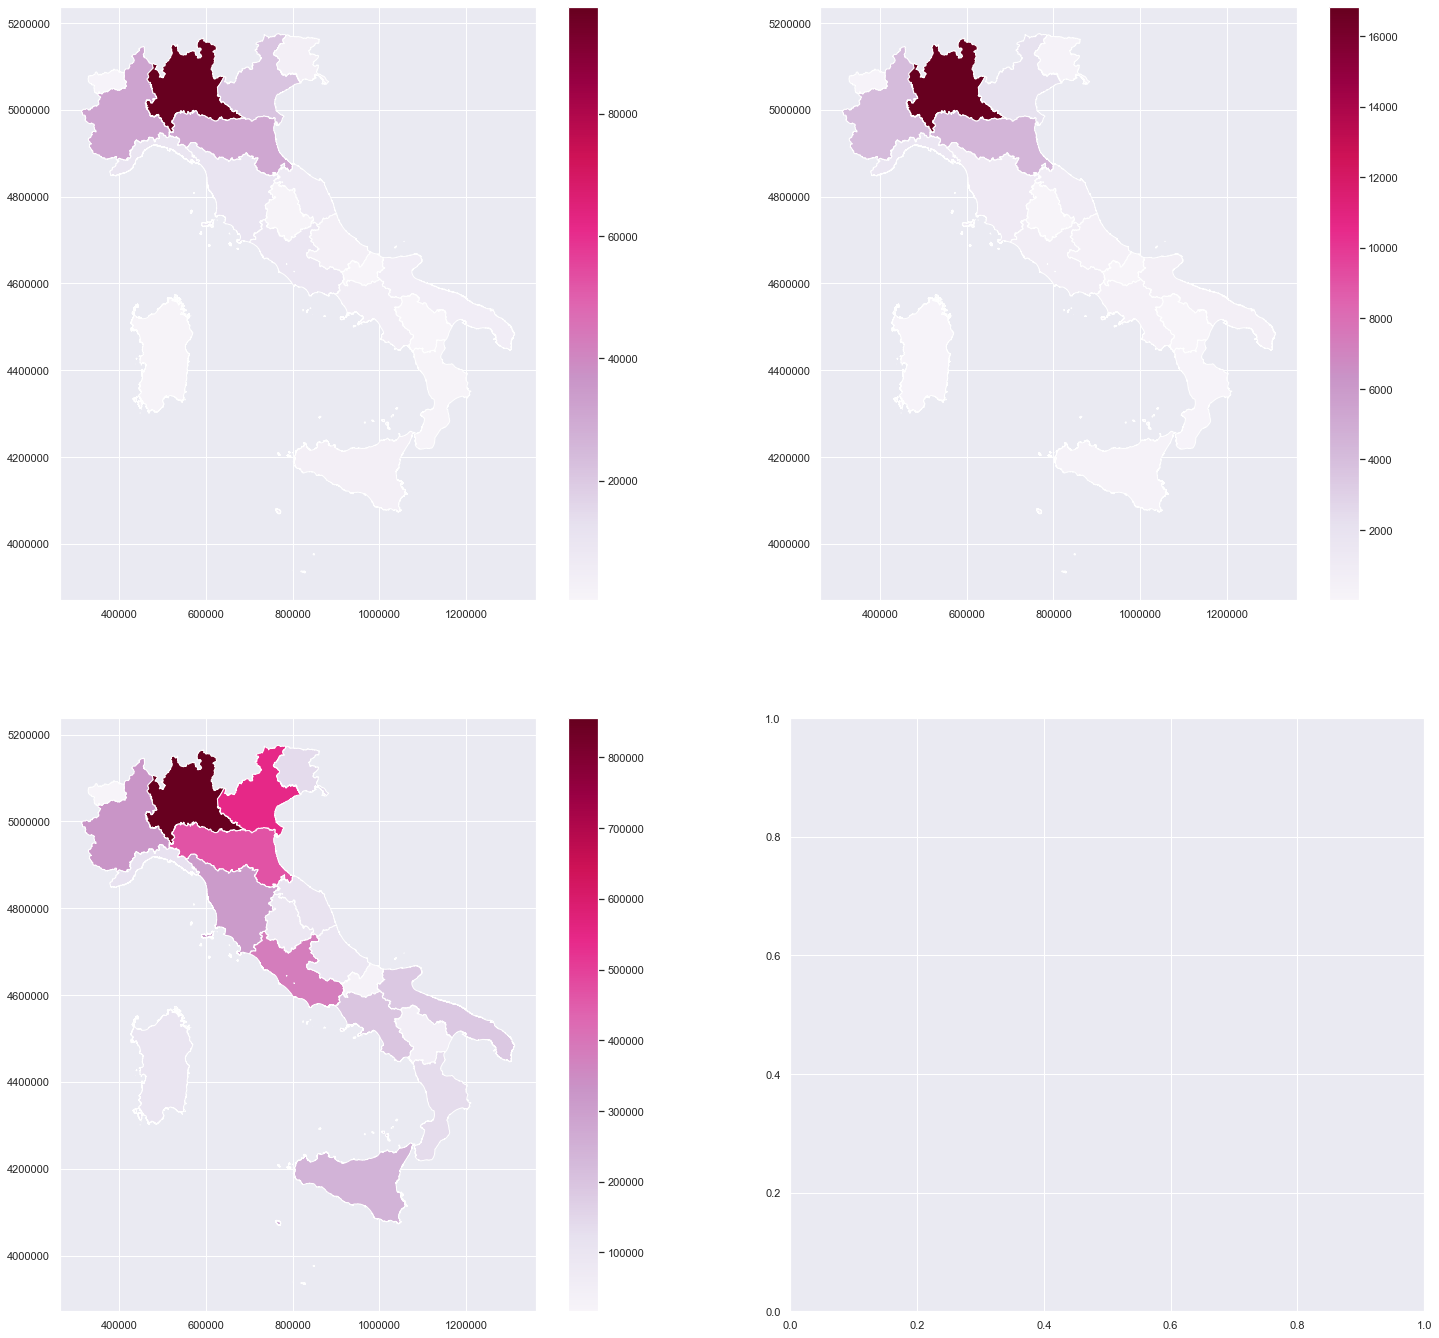

In [83]:
fig, axes = plt.subplots(2, 2, figsize=(25,24))
ax = geo_data_by_region.plot(ax=axes[0, 0], column='totale_casi', cmap="PuRd", legend=True)
ax = geo_data_by_region.plot(ax=axes[0, 1], column='deceduti', cmap="PuRd", legend=True)
ax = geo_data_by_region.plot(ax=axes[1, 0], column='casi_testati', cmap="PuRd", legend=True)

Qualche considerazione

In [ ]:
print("ciao")

Qualche tabella dei dati

Riportare anomalie: usare describe() per osservarle

Dati ISTAT per percentuali contagiati su popolazione

RIpetere grafico sopra per Morti, Ospedalizzati, ICU.

Heatmap regioni.

Heatmap punti province.

Heatmap province Lombardia.



In [ ]:
17584
13993